In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

# Input and format files

In [2]:
df_tag_counts = pd.read_csv('tag_counts.csv')
df_tag_counts.index = [int(x.split('_')[1].lstrip('0')) for x in df_tag_counts['file']]
df_tag_counts.sort_index(inplace=True)
# df_tag_counts['Article'] = df_tag_counts.index
print(df_tag_counts.shape)
df_tag_counts.head()

(219, 190)


file  private_vb  that_del  contract  vb_present  pro_2  \
25  n_0025_083_de_2007.txt         3.0       0.0       0.0        31.4    0.0   
27  c_0027_102_xx_2016.txt         3.8       0.3       0.0        22.4    0.0   
28  p_0028_014_br_2013.txt         3.4       0.0       0.0        18.2    0.0   
29  p_0029_091_xx_2016.txt         5.4       0.5       0.0        56.6    0.0   
30  p_0030_113_xx_2013.txt         3.9       0.1       0.0        25.6    0.3   

    do_pro  pro_dem  emphatic  pro_1  ...  Unnamed: 180  dim_1  dim_2  dim_3  \
25     0.0      0.0       1.5    3.7  ...             0 -28.58  -4.28   6.44   
27     0.0      0.6       0.3    4.7  ...             0 -29.78  -4.34   6.74   
28     0.5      0.0       0.7   26.6  ...             0 -25.49  -4.51   5.02   
29     0.3      0.0       1.9    3.5  ...             0 -20.52  -2.72   8.56   
30     0.0      0.6       0.4    4.7  ...             0 -26.89  -3.20   5.58   

    dim_4  dim_5                  file.1  tt_ratio  word_length  word_count  
25  -3.89   2.02  n_0025_083_de_2007.txt      34.0          5.5      1339.0  
27  -5.43   2.87  c_0027_102_xx_2016.txt      33.5          5.2      6569.0  
28  -5.95   3.27  p_0028_014_br_2013.txt      32.3          4.7      4064.0  
29  -1.38   3.97  p_0029_091_xx_2016.txt      32.5          5.3      3707.0  
30  -4.54   4.33  p_0030_113_xx_2013.txt      36.5          5.3      7256.0  

[5 rows x 190 columns]

In [3]:
# Import metadata
df = pd.read_csv('mapping_file_no_dups_matched_with_random_human.csv', index_col=0)
df = df[df['Pub Year'] != 1999]
df = df[np.isfinite(df['Randomized_number'])]
# Import CSV of raw texts
raw_text_df = pd.read_csv('raw_text_norefs.csv', index_col=0)
raw_text_df = raw_text_df[raw_text_df['Remaining'] != 0]

# Merge with metadata
df = df.merge(raw_text_df, left_on='Randomized_number', right_on='Article')
df_500 = df[df['Randomized_number']  < 501]
# Filter to only articles with consensus
df_500 = df_500[df_500['Consensus'].isin(['Con', 'Pro', 'Neutral'])]
print(df_500.shape)
df_500.index = df_500['Article']
df_500.head()

(230, 46)


Notes   Reference Type  \
Article                          
27       TRUE  Journal Article   
45        NaN  Journal Article   
65        NaN  Journal Article   
69        NaN  Journal Article   
70       TRUE  Journal Article   

                                          Authors, Primary  \
Article                                                      
27       Xia Hui;Zhang HongBin;Wang Wei;Yang Xiao;Wang ...   
45       Mason,Peter;Braun,Lorraine;Warwick,Suzanne I.;...   
65       Bohrerova,Zuzana;Bohrer,Gil;Cho,Ki Don;Bolch,M...   
69                       Soleri,Daniela;Cleveland,David A.   
70       Campagne,P.;Capdevielle-Dulac,C.;Pasquet,R.;Co...   

                                             Title Primary  \
Article                                                      
27       Ambient insect pressure and recipient genotype...   
45       Transgenic Bt-producing Brassica napus: Plutel...   
65       Determining the viability response of pine pol...   
69       Transgenic Maize and Mexican Maize Diversity: ...   
70       Genetic hitchhiking and resistance evolution t...   

                          Periodical Full Periodical Abbrev  Pub Year  \
Article                                                                 
27              Evolutionary Applications               NaN      2016   
45       Environmental Biosafety Research               NaN      2003   
65                Ecological Applications        Ecol.Appl.      2009   
69           Agriculture and Human Values               NaN      2006   
70                               Heredity  Heredity (Edinb)      2017   

        Pub Date Free From Volume Issue  ...  \
Article                                  ...   
27                     NaN      9     7  ...   
45        October-December      2   NaN  ...   
65                     APR     19     3  ...   
69                   6-Mar     23     1  ...   
70                     Apr    118     4  ...   

                                            Matching title Duplicated  \
Article                                                                 
27       Ambient insect pressure and recipient genotype...        NaN   
45       Transgenic Bt-producing Brassica napus Plutell...        NaN   
65       Determining the viability response of pine pol...        NaN   
69       Transgenic maize and Mexican maize diversity R...        NaN   
70       Genetic hitchhiking and resistance evolution t...        NaN   

        Randomized_number                            Randomized_number_title  \
Article                                                                        
27                     27  ambient insect pressure and recipient genotype...   
45                     45  transgenic btproducing brassica napus plutella...   
65                     65  determining the viability response of pine pol...   
69                     69  transgenic maize and mexican maize diversity r...   
70                     70  genetic hitchhiking and resistance evolution t...   

        Consensus  Funding Article Remaining  Removed  \
Article                                                 
27            Con      NaN      27     33294     9216   
45            Con      NaN      45     42253     9190   
65            Con      NaN      65     44040     8383   
69            Con      NaN      69     13955     6296   
70            Con      NaN      70     53038        0   

                                                      Text  
Article                                                     
27       evolutionary applications issn   o r i g i n a...  
45       environ biosafety res     isbr edp sciences  d...  
65       ecological applications   pp    by the ecologi...  
69       agriculture and human values    doi s  comment...  
70       heredity      macmillan publishers limited par...  

[5 rows x 46 columns]

# Counting words

In [6]:
df_500['transg_count'] = np.nan
df_500['gmo_count'] = np.nan
for index, row in df_500.iterrows():
    # Use lowercase
    word_count = row['Text'].count("transg")
    df_500.at[index, 'transg_count'] = word_count
    word_count = row['Text'].count("gmo")
    df_500.at[index, 'gmo_count'] = word_count
    word_count = row['Text'].count(" bt ")
    df_500.at[index, 'Bt_count'] = word_count
    word_count = row['Text'].count("glyphosate")
    df_500.at[index, 'roundup_count'] = word_count
    word_count = row['Text'].count('gene flow')
    df_500.at[index, 'gene_count'] = word_count
    word_count = row['Text'].count('cancer')
    df_500.at[index, 'cancer_count'] = word_count
    word_count = row['Text'].count('monarch')
    df_500.at[index, 'monarch_count'] = word_count

In [7]:
df_500_just_transg = df_500.copy()
print(df_500_just_transg.shape)
df_500_just_transg = df_500_just_transg[df_500_just_transg['transg_count'] > 0]
print(df_500_just_transg.shape)

(230, 53)
(204, 53)


In [8]:
df_500_just_transg[['transg_count','Consensus']].groupby('Consensus').mean()

transg_count
Consensus              
Con           41.000000
Neutral       24.585366
Pro           43.327273

In [9]:
# df_anova = df_500[df_500['transg_count'] > 0]
def anova_results(df, column):
    table = stats.f_oneway(df[df['Consensus'] == 'Neutral'][column],
                           df[df['Consensus'] == 'Positive'][column],
                           df[df['Consensus'] == 'Negative'][column])
    return table[0], table[1]

In [10]:
set(df_500['Consensus'])

{'Con', 'Neutral', 'Pro'}

In [14]:
df_500_bt_roundup = df_500[['Bt_count','roundup_count','transg_count','monarch_count','Consensus']].groupby('Consensus').mean()
df_500_bt_roundup['Bt_roundup_ratio'] = df_500_bt_roundup['Bt_count']/df_500_bt_roundup['roundup_count']
df_500_bt_roundup.reset_index(inplace=True)
df_500_bt_roundup.loc[3] = ['ANOVA F'] + [anova_results(df_500, 'Bt_count')[0],
                        anova_results(df_500, 'roundup_count')[0],
                        anova_results(df_500, 'transg_count')[0],
                        anova_results(df_500, 'monarch_count')[0],
                        np.nan]
df_500_bt_roundup.loc[4] = ['ANOVA P'] + [anova_results(df_500, 'Bt_count')[1],
                        anova_results(df_500, 'roundup_count')[1],
                        anova_results(df_500, 'transg_count')[1],
                        anova_results(df_500, 'monarch_count')[1],
                        np.nan]
# df_500_bt_roundup.to_csv('consensus_word_count_table.csv')
df_500_bt_roundup

Consensus   Bt_count  roundup_count  transg_count  monarch_count  \
0  Negative  20.838710      11.258065     34.387097       0.193548   
1   Neutral  10.187050       5.107914     21.755396       0.352518   
2  Positive  17.416667       1.750000     39.716667       0.200000   
3   ANOVA F   2.002578       1.775277      4.170434       0.063509   
4   ANOVA P   0.137365       0.171781      0.016645       0.938482   

   Bt_roundup_ratio  
0          1.851003  
1          1.994366  
2          9.952381  
3               NaN  
4               NaN

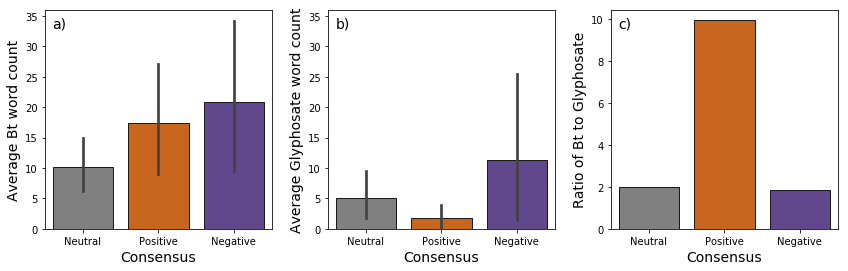

In [13]:
# Creating figure 3
fig, ax = plt.subplots(1,3, figsize = [12,4])

yaxes = ['"That" compl. cl.','Agentless passive verb','Nominalizations','All passives',
                      'Sum stance that comp. cl.','Topical attributive adj.','Transitive phrasal',
                       'Modals of possibility','All "the"','"To" compl. cl.','Abstract vs non-abstract',
                      'Proper nouns']
df_500['Consensus'] = df_500['Consensus'].replace('Con', 'Negative').replace('Pro', 'Positive')

ax[0] = sns.barplot('Consensus', 'Bt_count', data = df_500, order = ['Neutral','Positive','Negative'],
           palette = ['gray','#e66101','#5e3c99'], ax = ax[0], edgecolor='.1')
ax[0].set_ylim([0,36])
ax[0].set_ylabel("Average Bt word count", size = 14)
ax[0].set_xlabel("Consensus", size = 14)
ax[0].text(-0.4, 33, "a)", size=14)
ax[1] = sns.barplot('Consensus', 'roundup_count', data = df_500, order = ['Neutral','Positive','Negative'],
           palette = ['gray','#e66101','#5e3c99'], ax = ax[1], edgecolor='.1')
ax[1].set_ylim([0,36])
ax[1].set_ylabel("Average Glyphosate word count", size = 14)
ax[1].set_xlabel("Consensus", size = 14)
ax[1].text(-0.4, 33, "b)", size=14)
ax[2] = sns.barplot(['Negative','Neutral','Positive'], [1.85,1.99,9.96], order = ['Neutral','Positive','Negative'],
           palette = ['gray','#e66101','#5e3c99'], ax = ax[2], edgecolor='.1')
ax[2].set_ylabel("Ratio of Bt to Glyphosate", size = 14)
ax[2].set_xlabel("Consensus", size = 14)
ax[2].text(-0.4, 9.6, "c)", size = 14)

plt.tight_layout(pad=1.5)

In [15]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [16]:
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Neutral']['Bt_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Positive']['Bt_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Negative']['Bt_count']))

(10.18705035971223, 5.503238958318475, 14.870861761105987)
(17.416666666666668, 7.6024968499325105, 27.230836483400825)
(20.838709677419356, 7.36680146855584, 34.31061788628287)


In [17]:
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Neutral']['roundup_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Positive']['roundup_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Negative']['roundup_count']))

(5.107913669064748, 1.1065424605016245, 9.109284877627871)
(1.75, -0.3070877558099361, 3.807087755809936)
(11.258064516129032, -1.4292774318631842, 23.94540646412125)


In [18]:
con_glyphosate_avg = df_500[df_500['Consensus'] == 'Negative']['gene_count'].mean()
pro_glyphosate_avg = df_500[df_500['Consensus'] == 'Positive']['gene_count'].mean()
print(con_glyphosate_avg/pro_glyphosate_avg)

3.838709677419355


In [19]:
df_500[['gene_count','Consensus']].groupby('Consensus').mean()

gene_count
Consensus            
Negative     3.838710
Neutral      2.122302
Positive     1.000000

In [20]:
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Neutral']['gene_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Positive']['gene_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Negative']['gene_count']))

(2.1223021582733814, 0.2580686047798757, 3.986535711766887)
(1.0, 0.2257479051738298, 1.7742520948261702)
(3.838709677419355, 0.6718639960985899, 7.00555535874012)


In [21]:
df_500[['gene_count','Consensus']].groupby('Consensus').mean()

gene_count
Consensus            
Negative     3.838710
Neutral      2.122302
Positive     1.000000

In [20]:
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Neutral']['cancer_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Positive']['cancer_count']))
print(mean_confidence_interval(df_500[df_500['Consensus'] == 'Negative']['cancer_count']))

(0.35251798561151076, -0.23295127808967092, 0.9379872493126924)
(0.016666666666666666, -0.01668325628413683, 0.05001658961747016)
(1.4516129032258065, -1.5129761462437314, 4.416201952695344)


In [35]:
anova_results(df_500, 'Bt_count')

(2.0025776552197274, 0.13736465796701489)

Text(0.1,0.95,'b)')

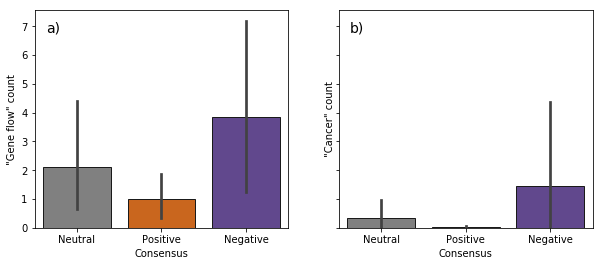

In [22]:
# MAking figure 2
fig, ax = plt.subplots(1,2, figsize = [10,4], sharey = True)

sns.barplot('Consensus', 'gene_count', data = df_500, order = ['Neutral','Positive','Negative'],
                    palette = ['gray','#e66101','#5e3c99'], edgecolor='.1', ax = ax[0])
ax[0].set_ylabel('"Gene flow" count')
ax[0].annotate('a)', xy=(0.1, 0.95), xycoords='axes fraction',
                          horizontalalignment='right', verticalalignment='top', size=14)

sns.barplot('Consensus', 'cancer_count', data = df_500, order = ['Neutral','Positive','Negative'],
                    palette = ['gray','#e66101','#5e3c99'], edgecolor='.1', ax = ax[1])
ax[1].set_ylabel('"Cancer" count')
ax[1].annotate('b)', xy=(0.1, 0.95), xycoords='axes fraction',
                          horizontalalignment='right', verticalalignment='top', size=14)

In [23]:
print(mean_confidence_interval(country_df[(country_df['Consensus'] == 'Negative') & (country_df['Country'] == 'Other')]['cancer_count']))
print(mean_confidence_interval(country_df[(country_df['Consensus'] == 'Neutral') & (country_df['Country'] == 'Other')]['cancer_count']))
print(mean_confidence_interval(country_df[(country_df['Consensus'] == 'Neutral') & (country_df['Country'] == 'USA')]['cancer_count']))
print(mean_confidence_interval(country_df[(country_df['Consensus'] == 'Neutral') & (country_df['Country'] == 'EU')]['cancer_count']))
print(mean_confidence_interval(country_df[(country_df['Consensus'] == 'Positive') & (country_df['Country'] == 'Other')]['cancer_count']))

(2.5, -2.774538944582953, 7.774538944582953)
(0.4782608695652174, -0.4075653897454896, 1.3640871288759244)
(0.16666666666666666, -0.18496926297219682, 0.5183025963055301)
(0.1111111111111111, -0.12331284198146453, 0.34553506420368674)
(0.02857142857142857, -0.029492700266220518, 0.08663555740907766)


In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
moore_lm = ols('roundup_count ~ Consensus',data=df_500).fit()
table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 Anova DataFrame
print(table)

                  sum_sq     df         F    PR(>F)
Consensus    1848.581047    2.0  1.775277  0.171781
Residual   118186.566779  227.0       NaN       NaN


In [25]:
df_500[['transg_count','Consensus']].groupby('Consensus').mean()

transg_count
Consensus              
Negative      34.387097
Neutral       21.755396
Positive      39.716667

In [24]:
print(df_anova[['transg_count','Consensus']].groupby('Consensus').mean())
print(df_anova[['transg_count','Consensus']].groupby('Consensus').std())

           transg_count
Consensus              
Negative      34.387097
Neutral       21.755396
Positive      39.716667
           transg_count
Consensus              
Negative      44.386693
Neutral       28.505998
Positive      63.075175


In [28]:
print(df_anova[['transg_count','Consensus']].count())

transg_count    230
Consensus       230
dtype: int64


In [29]:
moore_lm = ols('transg_count ~ Consensus',data=df_anova).fit()
table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 Anova DataFrame
print(table)

                  sum_sq     df         F    PR(>F)
Consensus   14917.043592    2.0  4.170434  0.016645
Residual   405973.221625  227.0       NaN       NaN


[Text(0,0,'Neutral'), Text(0,0,'Positive'), Text(0,0,'Negative')]

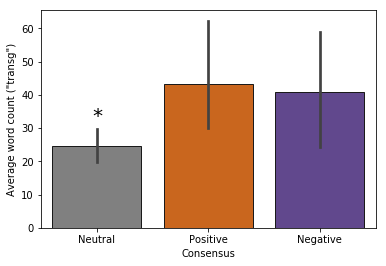

In [25]:
color = ['gray','#e66101','#5e3c99']
ax = sns.barplot('Consensus','transg_count', data = df_500[df_500['transg_count'] > 0], 
            palette = color, order = ['Neutral','Positive','Negative'], edgecolor='.1')
plt.ylabel('Average word count ("transg")')
plt.annotate('*', ha = 'center',
             xy=(0.003, 32), size = 20, 
             xycoords='data')
ax.set_xticklabels(['Neutral','Positive','Negative'])

In [27]:
#genus counts
genera = ['medicago sativa','brassica napus','phaseolus vulgaris','dianthus caryophyllus','cichorium intybus',
          'gossypium hirsutum','grostis stolonifera','solanum melongena','linum usitatissumum','zea mays',
          'cucumis melo','carica papaya','petunia hybrida','prunus domestica','brassica rapa',
         'populus','solanum tuberosum','oryza sativa','rosa hybrida','glycine max','ucurbita pepo',
          'beta vulgaris','saccharum','capsicum annuum','nicotiana tabacum','lycopersicon esculentum',
          'triticum aestivum']
genera_df = pd.DataFrame(index = ['count'])
max_word_count = {}
for genus in genera:
    word_count = 0
    max_word_count[genus] = 0
    for index, row in df_500.iterrows():
    # Use lowercase
        word_count += row['Text'].count(genus)
        
        df_500.at[index, genus] = word_count
            
#         word_count = 
    genera_df[genus] = word_count

In [28]:
genera_df_percent = genera_df.T
genera_df_percent['Percent'] = (100. * genera_df_percent / genera_df_percent.sum()).round(0)
genera_df_percent.sort_values('count', inplace=True, ascending=False)
genera_df_percent.to_csv('genus_count.csv')
genera_df_percent

count  Percent
zea mays                   128     15.0
brassica napus             125     14.0
populus                    122     14.0
oryza sativa               110     13.0
triticum aestivum           74      8.0
glycine max                 52      6.0
nicotiana tabacum           45      5.0
gossypium hirsutum          44      5.0
brassica rapa               41      5.0
beta vulgaris               22      3.0
phaseolus vulgaris          21      2.0
grostis stolonifera         16      2.0
ucurbita pepo               14      2.0
solanum tuberosum           14      2.0
medicago sativa             14      2.0
saccharum                   10      1.0
capsicum annuum             10      1.0
lycopersicon esculentum      5      1.0
petunia hybrida              3      0.0
carica papaya                3      0.0
solanum melongena            1      0.0
cichorium intybus            1      0.0
prunus domestica             1      0.0
cucumis melo                 0      0.0
rosa hybrida                 0      0.0
linum usitatissumum          0      0.0
dianthus caryophyllus        0      0.0

# Supervised classification

In [29]:
# Merge data with tag counts
df_tags_metadata = pd.concat([df_500,df_tag_counts], axis=1, sort=False)
df_tags_metadata = df_tags_metadata[df_tags_metadata['word_count'] > 0]
# Fitlering to just numeric data
df_tags_metadata_numeric = df_tags_metadata.loc[:,'private_vb':]
df_tags_metadata_numeric['trangs_count'] = df_tags_metadata['transg_count']
df_tags_metadata_numeric.drop(['file.1'], axis=1, inplace = True)
print df_tags_metadata_numeric.shape
df_tags_metadata_numeric[:5]

(219, 189)


private_vb  that_del  contract  vb_present  pro_2  do_pro  pro_dem  \
25         3.0       0.0       0.0        31.4    0.0     0.0      0.0   
27         3.8       0.3       0.0        22.4    0.0     0.0      0.6   
28         3.4       0.0       0.0        18.2    0.0     0.5      0.0   
29         5.4       0.5       0.0        56.6    0.0     0.3      0.0   
30         3.9       0.1       0.0        25.6    0.3     0.0      0.6   

    emphatic  pro_1  pro_it  ...  Unnamed: 180  dim_1  dim_2  dim_3  dim_4  \
25       1.5    3.7     6.0  ...           0.0 -28.58  -4.28   6.44  -3.89   
27       0.3    4.7     2.4  ...           0.0 -29.78  -4.34   6.74  -5.43   
28       0.7   26.6     1.2  ...           0.0 -25.49  -4.51   5.02  -5.95   
29       1.9    3.5     6.2  ...           0.0 -20.52  -2.72   8.56  -1.38   
30       0.4    4.7     1.2  ...           0.0 -26.89  -3.20   5.58  -4.54   

    dim_5  tt_ratio  word_length  word_count  trangs_count  
25   2.02      34.0          5.5      1339.0           0.0  
27   2.87      33.5          5.2      6569.0         182.0  
28   3.27      32.3          4.7      4064.0          12.0  
29   3.97      32.5          5.3      3707.0           0.0  
30   4.33      36.5          5.3      7256.0          51.0  

[5 rows x 189 columns]

In [30]:
# Columns to include in supervised classification
columns = ['th_nn_likely','th_nn_stance_all','mod_poss','all_def_art','to_vb_speech','nn_proper',
           'nn_quant','vb_be','tpv_mental','vb_perfect','mod_all','comm_vb_other','nn_nom','jj_topic',
           'jj_time','pv_copular','pro_3'] 

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(df_tags_metadata_numeric.values,df_tags_metadata['Consensus'].values, 
                                                                test_size=0.5, random_state=42)

In [36]:
# Data on the split and ratio
print list(Y_train).count('Negative')
print list(Y_train).count('Negative')/float(list(Y_test).count('Negative'))
print list(Y_train).count('Positive')
print list(Y_train).count('Positive')/float(list(Y_test).count('Positive'))
print list(Y_train).count('Neutral')
print list(Y_train).count('Neutral')/float(list(Y_test).count('Neutral'))

16
1.06666666667
27
0.84375
66
1.04761904762


# ANOVA

In [47]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [37]:
anova_df = pd.DataFrame()
mean_ci_df = pd.DataFrame()
statistics = []
p_values = []
levene = []
variance = {'Neutral':[],'Positive': [], 'Negative': []}
means ={'Neutral':[],'Positive': [], 'Negative': []}
lowers = {'Neutral':[],'Positive': [], 'Negative': []}
uppers = {'Neutral':[],'Positive': [], 'Negative': []}

df_tags_metadata['Consensus'] = df_tags_metadata['Consensus'].replace('Pro', 'Positive').replace('Con','Negative')
for column in df_tags_metadata_numeric:
    
    neutral = df_tags_metadata_numeric[df_tags_metadata_numeric.index.isin(df_tags_metadata[df_tags_metadata['Consensus'] == 'Neutral'].index)][column]
    pro = df_tags_metadata_numeric[df_tags_metadata_numeric.index.isin(df_tags_metadata[df_tags_metadata['Consensus'] == 'Positive'].index)][column]
    con = df_tags_metadata_numeric[df_tags_metadata_numeric.index.isin(df_tags_metadata[df_tags_metadata['Consensus'] == 'Negative'].index)][column]
    
    statistic, p_value = stats.f_oneway(pro,con,neutral)
    statistics.append(statistic)
    p_values.append(p_value)
    levene.append(stats.levene(pro,con,neutral)[1])
    for i in ['Neutral','Positive','Negative']:
        mean_confidence = mean_confidence_interval(df_tags_metadata_numeric[df_tags_metadata['Consensus'] == i][column])
        means[i].append(mean_confidence[0])
        lowers[i].append(mean_confidence[1])
        uppers[i].append(mean_confidence[2])
        variance[i].append(np.var(df_tags_metadata_numeric[df_tags_metadata['Consensus'] == i][column]))

anova_df['Columns'] = df_tags_metadata_numeric.columns.values
anova_df['Statistic'] = statistics
anova_df['P_value_onewayanova'] = p_values
anova_df['P_value_Levene'] = levene
anova_df['Neutral_mean'] = means['Neutral']
anova_df['Neutral_lower'] = lowers['Neutral']
anova_df['Neutral_upper'] = uppers['Neutral']
anova_df['Positive_mean'] = means['Positive']
anova_df['Positive_lower'] = lowers['Positive']
anova_df['Positive_upper'] = uppers['Positive']
anova_df['Negative_mean'] = means['Negative']
anova_df['Negative_lower'] = lowers['Negative']
anova_df['Negative_upper'] = uppers['Negative']
anova_df['Neutral_variance'] = variance['Neutral']
anova_df['Negative_variance'] = variance['Negative']
anova_df['Positive_variance'] = variance['Positive']
anova_df['Levene_ratio'] = anova_df[['Neutral_variance','Positive_variance','Negative_variance']].max(axis=1)/anova_df[['Neutral_variance','Positive_variance','Negative_variance']].min(axis=1)
anova_df.sort_values('Statistic', ascending=False, inplace=True)

/home/bostevens/.local/lib/python2.7/site-packages/scipy/stats/stats.py:2961: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw
/home/bostevens/.local/lib/python2.7/site-packages/scipy/stats/morestats.py:2345: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [38]:
anova_df[['Columns','Statistic','Levene_ratio']].head(n=20)

Columns  Statistic  Levene_ratio
112      th_nn_likely  13.010313      9.193654
43      passive_short   9.484800      1.553284
32             nn_nom   9.086037      1.369676
52        passive_all   8.269083      3.105615
131  th_nn_stance_all   7.941194      3.070436
171          jj_topic   7.446330      2.752515
153      tpv_mental.1   5.902847     30.530549
17           mod_poss   5.876095      1.940217
77        all_def_art   5.520702      1.780126
123  to_nn_stance_all   5.331055      2.869992
184             dim_5   5.134759      2.638770
80          nn_proper   4.723169      2.215927
24            vb_past   4.693892      1.181218
155        pv_copular   4.690194           inf
82        Unnamed: 83   4.649754     17.993705
67      fact_vb_other   4.636582      1.722040
26         vb_perfect   4.505742      1.780575
103         th_vb_att   4.282226      1.882319
150           ipv_act   4.262005           inf
9              pro_it   4.183971      1.646941

In [39]:
def get_letters(results):
    if results[2] == True and results[1] == True and results[0] == True:
        letters = ['a','b','c']
    if results[2] == False and results[1] == True and results[0] == True:
        letters = ['a','a','b']
    if results[2] == False and results[1] == False and results[0] == True:
        letters = ['a','ab','b']
    if results[2] == False and results[1] == True and results[0] == False:
        letters = ['ab','a','b']

    if results[2] == True and results[1] == False and results[0] == True:
        letters = ['a','b','b']
    if results[2] == True and results[1] == False and results[0] == False:
        letters = ['a','b','ab']
    if results[2] == True and results[1] == True and results[0] == False:
        letters = ['a','b','a']

    if results[2] == True and results[1] == True and results[0] == True:
        letters = ['a','b','bc']
    if results[2] == True and results[1] == False and results[0] == False:
        letters = ['a','b','ab']

    if results[2] == False and results[1] == False and results[0] == False:
        letters = ['a','a','a']
    return letters

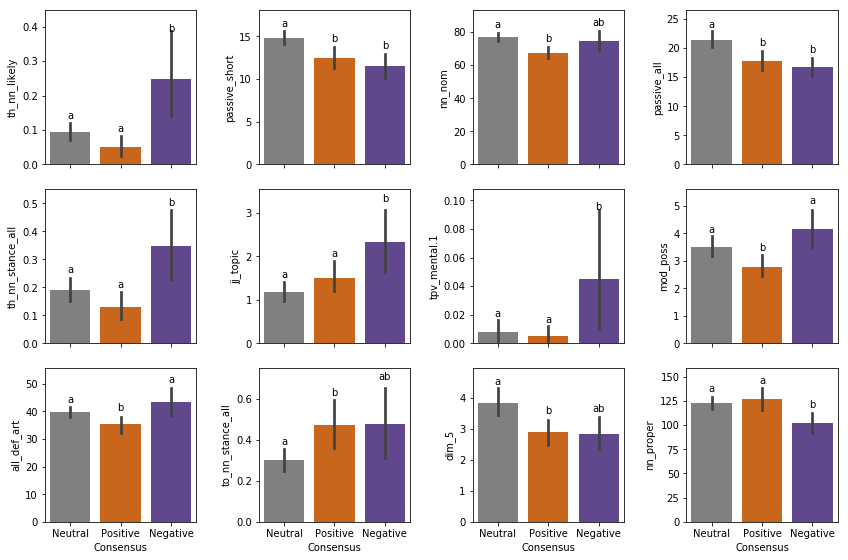

In [40]:
# Creating figure of tag count statistics
fig, ax = plt.subplots(3,4, figsize = [12,8], sharex=True)

yaxes = anova_df.head(n = 12)['Columns'].values
k = 0
l = 0
for i in range(1,4):
    if i == 2:
        k = 3
    if i == 3:
        k = 6
    for j in range(1,5):
        yaxis = anova_df.head(n = 12)['Columns'].iloc[i+k-1]
        k += 1
#         print yaxis
        axs = ax[i-1][j-1]
        sns.barplot('Consensus', yaxis, data = df_tags_metadata, order = ['Neutral','Positive','Negative'],
           palette = ['gray','#e66101','#5e3c99'], ax = axs)#, edgecolor='.1')
        ylim = axs.get_ylim()
        axs.set_ylim(0,ylim[1]*1.1)
        if i != 3:
            axs.set_xlabel('')
        tukey_results = pairwise_tukeyhsd(df_tags_metadata[yaxis], df_tags_metadata['Consensus'])
        letters = get_letters(tukey_results.reject)
        
        data_neutral = df_tags_metadata[df_tags_metadata['Consensus'] == 'Neutral'][yaxis].values
        height_neutral = mean_confidence_interval(data_neutral)[2]
        axs.annotate(letters[0],xy=(0,height_neutral), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords= "offset points", 
                     ha='center', va='bottom')
        data_pro = df_tags_metadata[df_tags_metadata['Consensus'] == 'Positive'][yaxis].values
        height_pro = mean_confidence_interval(data_pro)[2]
        axs.annotate(letters[1],xy=(1,height_pro), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords= "offset points", 
                     ha='center', va='bottom')
        data_con = df_tags_metadata[df_tags_metadata['Consensus'] == 'Negative'][yaxis].values
        height_con = mean_confidence_interval(data_con)[2]
        axs.annotate(letters[2],xy=(2,height_con), 
                xytext=(0, 3),  # 3 points vertical offset
                textcoords= "offset points", 
                     ha='center', va='bottom')
        axs.set_ylabel(yaxes[l])
        l += 1
            
plt.tight_layout(pad=1.5)

# Random forest

In [42]:
accuracy_list = []
random_chance_list = []
for i in range(50):
    X_train, X_test, Y_train, Y_test = train_test_split(df_tags_metadata_numeric[anova_df.head(n = 12)['Columns'].values].values,df_tags_metadata['Consensus'].values, 
                                                                        test_size=0.3, random_state=i)
    param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [2,3,4,5,6,7,8,9,10],
        'criterion' :['gini', 'entropy']
    }
    rfc=RandomForestClassifier(random_state=42)
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, Y_train)
    predicted = CV_rfc.predict(X_test)
#     clf = RandomForestClassifier(n_estimators=200, max_features='auto', max_depth=6, random_state=42, criterion= 'gini')
#     clf.fit(X_train, Y_train)
#     predicted = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, predicted)
    sum_counter = float(Counter(Y_test)['Positive'] + Counter(Y_test)['Negative']+ Counter(Y_test)['Neutral'])
    random_chance = round((Counter(Y_test)['Positive']/sum_counter)**2+(Counter(Y_test)['Negative']/(sum_counter))**2+(Counter(Y_test)['Neutral']/(sum_counter))**2,2)
    random_chance_list.append(random_chance)
    accuracy_list.append(accuracy)

/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selec

/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bostevens/.local/lib/python2.7/site-packages/sklearn/model_selec

In [43]:
print(CV_rfc.best_params_)

{'max_features': 'auto', 'n_estimators': 200, 'criterion': 'gini', 'max_depth': 8}


In [45]:
accuracy_list = []
random_chance_list = []
for i in range(50):
    X_train, X_test, Y_train, Y_test = train_test_split(df_tags_metadata_numeric[anova_df.head(n = 12)['Columns'].values].values,df_tags_metadata['Consensus'].values, 
                                                                        test_size=0.3, random_state=i)

    clf = RandomForestClassifier(n_estimators=200, max_features='auto', max_depth=6, random_state=42, criterion= 'gini')
    clf.fit(X_train, Y_train)
    predicted = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, predicted)
    sum_counter = float(Counter(Y_test)['Positive'] + Counter(Y_test)['Negative']+ Counter(Y_test)['Neutral'])
    random_chance = round((Counter(Y_test)['Positive']/sum_counter)**2+(Counter(Y_test)['Negative']/(sum_counter))**2+(Counter(Y_test)['Neutral']/(sum_counter))**2,2)
    random_chance_list.append(random_chance)
    accuracy_list.append(accuracy)

In [46]:
print sum(accuracy_list)/len(accuracy_list)
print sum(random_chance_list)/len(random_chance_list)

0.6387878787878789
0.4438


In [61]:
# Statistics on random chance
rf = {'Random':random_chance_list, 'Accuracy':accuracy_list}
df_rf_anova = pd.DataFrame(data = rf)
moore_lm = ols('Accuracy ~ Random',data=df_rf_anova).fit()
table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 Anova DataFrame
print(table)

            sum_sq    df          F        PR(>F)
Random    0.066881   1.0  51.403414  4.042443e-09
Residual  0.062453  48.0        NaN           NaN
